# Segment

In this notebook, we demonstrate and compare techniques for segmentation and classification of crops using Planet imagery. A metric will be established to quantify accuracy of crop classification and will be used to compare technique results.

## Usage Notes

This notebook was developed in a Docker container. This [Dockerfile](Dockerfile) was used to build the image.

This notebook expects that the following scene has been downloaded into the data sub-dir directory: '20160831_180231_0e0e_3B_AnalyticMS.tif'

In [16]:
from collections import namedtuple
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio

%matplotlib inline

## Load Image

Here we define the image path, check that it exists, then define some helper functions for loading the image. We don't actually load the image until later on to avoid running out of memory.

In [33]:
image_filename = os.path.join('data', '20160831_180231_0e0e_3B_AnalyticMS.tif')
assert os.path.isfile(image_filename)

In [34]:
# NOTE: Not sure a namedtuple is what we want long-term. It is used now because:
# memory footprint is smaller than a masked ndarray (where the same mask is repeated across all bands)
# response is faster than rasterio read(), which appears to read from the file vs. caching

# Saves the image bands and image mask separately
# Bands is a 16-bit ndarray representing band pixels
# Mask is a boolean 2d array identifying nodata pixels
MaskedImage = namedtuple('MaskedImage', 'bands, mask')

def load_masked_image(filename):
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
        return MaskedImage(bands=np.dstack([r, g, b, nir]), mask=mask)
# img = load_masked_image(image_filename)
# del img

def create_masked_array(masked_image):
    # recast 2d mask to 3d, repeating across 3rd axis
    mask = np.broadcast_to(np.atleast_3d(masked_image.mask),
                           masked_image.bands.shape)
    return ma.masked_array(masked_image.bands, mask)
# masked_img = create_masked_array(load_masked_image(image_filename))
# del masked_img

In [52]:
with rasterio.open(image_filename) as src:
    print dir(src)

['__class__', '__delattr__', '__dict__', '__doc__', '__enter__', '__exit__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_block_shapes', '_closed', '_count', '_crs', '_crs_wkt', '_descriptions', '_dtypes', '_gcps', '_handle_crswkt', '_has_band', '_mask_flags', '_nodatavals', '_read', '_transform', '_units', 'affine', 'block_shapes', 'block_windows', 'bounds', 'checksum', 'close', 'closed', 'colorinterp', 'colormap', 'compression', 'count', 'crs', 'dataset_mask', 'descriptions', 'driver', 'dtypes', 'gcps', 'get_crs', 'get_gcps', 'get_nodatavals', 'get_transform', 'height', 'index', 'indexes', 'interleaving', 'is_tiled', 'kwds', 'lnglat', 'mask_flag_enums', 'mask_flags', 'meta', 'mode', 'name', 'nodata', 'nodatavals', 'options', 'overviews', 'photometric', 'profile', 'read', 'read_crs', 'read_mask', 'read_masks', '

## Display Image

The image is 16-bit, 4-band, and contains nodata pixels defined by a mask. Matplotlib's `imshow()` function, which we use for display, expects a 3-band, 8-bit numpy array and has no concept of masks. Therefore, some processing and scaling is required for display.

In [35]:
def linear_scale(img, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (img - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def to_8_bit(img, old_min, old_max):
    """Converts the image to 8-bit using linear scaling and clipping to 8-bit min/max"""
    new_min = 0
    new_max = 2**8 - 1
    scaled = linear_scale(img.astype(np.double), old_min, old_max, new_min, new_max)
    return np.clip(scaled, new_min, new_max).astype(np.uint8)
print(to_8_bit(np.array([1,2,10,100,256,2560, 2660]), 2, 2560))

[ -1   0   0   9  25 256 266]
[  0   0   0   9  25 255 255]


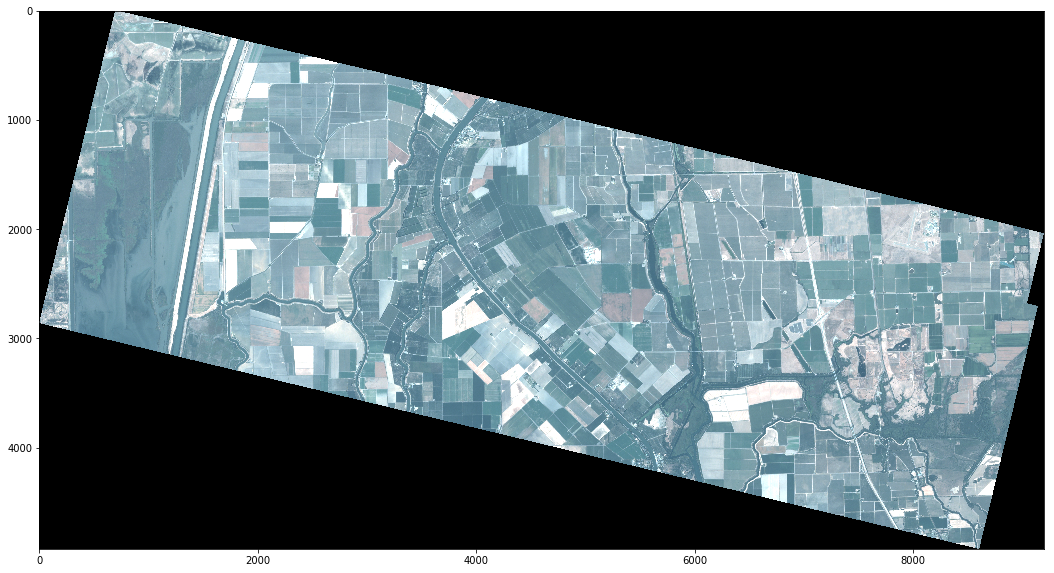

In [36]:
def to_display(masked_image):
    """Converts the masked image to a 3-band rgb, 8-bit array for display."""
    rgb_bands = create_masked_array(masked_image)[:,:,:3]
#     old_min = rgb_bands.min()
#     old_max = rgb_bands.max()
    old_min = np.percentile(rgb_bands, 2) # looks prettier than using the min val
    old_max = np.percentile(rgb_bands, 98) # looks prettier than using the max val
    return to_8_bit(rgb_bands, old_min, old_max)

plt.figure(1,figsize=(18,36))
plt.imshow(to_display(load_masked_image(image_filename)))

## Display dataset over image

Steps we need to take:
- project dataset to image crs
- crop dataset to image extents
- display image and dataset (ipyleaflet or other widget?)

This assumes that the survey data has been downloaded and extracted, see [Notebook](crop-segmentation-and-classification.ipynb#Downloading-data).

In [42]:
from functools import partial

import fiona
import pyproj
import shapely

In [29]:
# Let's specify the shapefile location and ensure it indeed exists
survey_shapefile = 'data/dwr_survey/SA15.shp'
assert os.path.isfile(survey_shapefile)

##### Define projection

In [ ]:
# What is the coordinate reference system for this dataset?
with fiona.open(survey_shapefile, 'r') as survey_data:
    src_proj = survey_data.crs['init']
print(src_proj)

In [45]:
# What is the coordinate reference system for the image?
with rasterio.open(image_filename) as img:
    dst_proj = img.crs['init']
print(dst_proj)

epsg:32610


So the dataset is in NAD83 / UTM zone 10N ([src](http://spatialreference.org/ref/epsg/26910/)) but the image is in WGS84 / UTM zone 10N ([src](http://spatialreference.org/ref/epsg/32610/)). We need to project the dataset to the image crs.

We will define the projection here and then use that projection when the dataset is loaded. A lot of this is from this sister [notebook](http://192.168.99.100:8888/notebooks/work/crop-segmentation-and-classification.ipynb#Downloading-data).

In [47]:
# define projection
# from shapely [docs](http://toblerity.org/shapely/manual.html#shapely.ops.transform)
project_to_wkt = partial(
    pyproj.transform,
    pyproj.Proj(init=src_proj),
    pyproj.Proj(init=dst_proj))

def project_feature(feat):
    g1 = shape(feat['geometry'])
    g2 = transform(project_to_wkt, g1)
    feat['geometry'] = mapping(g2)

##### Filter to agricultural classes

In [48]:
agg_classes = ['G', 'R', 'F', 'P', 'T', 'D', 'C', 'V']

def is_agricultural(feat):
    return feat['properties']['CLASS1'] in agg_classes

##### Clip to features overlapping image

In [ ]:
box_shape = shape(geo_json['geometry'])
contained_features = [f for f in features
                      if shape(f['geometry']).within(box_shape)]